In [1]:
import glob
import torch
from torch.utils import data
from PIL import Image
import numpy as np
from torchvision import transforms
import matplotlib.pyplot as plt
import pandas as pd
from ahrs.filters import Madgwick
from ahrs.common.orientation import q2euler
from PIL import Image, ImageDraw
import os
import seaborn as sns


torch.cuda.set_device(1)  # 3 指的是第三块 GPU


# Function to plot heatmap
def plot_heatmap(x, y, value, title,signature_id):
    # Create a pivot table with mean value for each x,y position
    
    heatmap_data = pd.pivot_table(data, values=value, index='y', columns='x', aggfunc=np.mean)
    heatmap_data = heatmap_data.T  # 转置DataFrame
    # Plot heatmap
    plt.figure(figsize=(10, 8))
    plt.title(title)
    sns.heatmap(heatmap_data, cmap='viridis', cbar=False)
    plt.gca().invert_yaxis()  # Invert y axis to match the coordinate system
    

    save_dir='hm_data/'
    base_dir = os.path.splitext(signature_id)[0]  # 基础文件夹路径
    base_dir =os.path.basename(base_dir)

    signature_folder_name = os.path.splitext(title)[0] + '.png'


    target_dir = os.path.join(save_dir,base_dir)
    print(target_dir)

    if not os.path.exists(target_dir):
        os.makedirs(target_dir)

    file_path = os.path.join(target_dir, signature_folder_name)
    plt.savefig(file_path)
    # plt.show()  # 显示图像
    # plt.close()
    




/home/yl7723/miniconda3/envs/test/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/tmp/ipykernel_1091018/1776166531.py:8: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [2]:
#通过创建data.Dataset子类Mydataset来创建输入
class Mydataset(data.Dataset):
# 类初始化
    def __init__(self, root):
        self.data_path = root
# 进行切片
    def __getitem__(self, index):
        img_path = self.data_path[index]
        return img_path
# 返回长度
    def __len__(self):
        return len(self.data_path)


data_path =  sorted(glob.glob(r'/home/yl7723/work/AML_LAB/imu_data/*.csv'))#数据文件夹路径，根据实际情况更改！！
new_imu_dir = '/home/yl7723/work/AML_LAB/hm_data' 
signature_dataset = Mydataset(data_path)
print(len(signature_dataset)) #返回文件夹中图片总个数


species = ['False','True']
species_to_id = dict((c, i) for i, c in enumerate(species))
#print(species_to_id)
id_to_species = dict((v, k) for k, v in species_to_id.items())
#print(id_to_species)
all_labels = []
#对所有图片路径进行迭代
for imu in data_path:
    # 区分出每个img，应该属于什么类别
    for i, c in enumerate(species):
        if c in imu:
            all_labels.append(i)
print(all_labels) #得到所有标签 

120
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]


In [13]:
# data_path = sorted(glob.glob(r'/AML_LAB/imu_data/*.csv'))#数据文件夹路径，根据实际情况更改！
# for var in data_path:
#     data = pd.read_csv(var)
#     plot_heatmap(data['x'], data['y'], 'pressure', 'Pressure',var)
#     # Plot heatmap for pitch
#     plot_heatmap(data['x'], data['y'], 'pitch', 'Pitch',var)

#     # Plot heatmap for roll
#     plot_heatmap(data['x'], data['y'], 'roll', 'Roll',var)

#     # Plot heatmap for yaw
#     plot_heatmap(data['x'], data['y'], 'yaw', 'Yaw',var)

In [3]:
from PIL import Image
import numpy as np
import glob
from torch.utils.data import Dataset
import torchvision.transforms as transforms

class SignatureDataset(Dataset):
    def __init__(self, root_dir, labels,transform=None):
        """
        root_dir: 存储所有图像的根目录路径
        transform: 应用于每个堆叠图像的转换操作
        """
        self.root_dir = root_dir
        self.transform = transform
        self.labels = labels
        # 假设每个签名的文件夹都存储了四个通道的图像
        self.signatures = sorted(glob.glob(root_dir + '/*/'))
        
                        
    def __len__(self):
        return len(self.signatures)

    def __getitem__(self, idx):
        signature_dir = self.signatures[idx]
        channels = ['Pressure', 'Pitch', 'Roll', 'Yaw']
        images = []
        label = self.labels[idx]
        for channel in channels:
            img_path_list = sorted(glob.glob(signature_dir + f'*{channel}.png'))  # 这将返回一个列表
            if img_path_list:  # 确保列表不为空
                img_path = img_path_list[0]  # 选择列表中的第一个元素
                image = Image.open(img_path).convert('L')  # 现在img_path是一个字符串，指向文件路径
                images.append(np.array(image))
            else:
                print(f"No image found for channel {channel} in {signature_dir}")

        # 堆叠图像
        stacked_image = np.stack(images, axis=-1)

        if self.transform:
            # 如果transform期望的是PIL图像，需要先将numpy数组转换回PIL图像
            stacked_image = Image.fromarray(stacked_image)
            stacked_image = self.transform(stacked_image)

        return stacked_image,label

# 定义转换操作
transform = transforms.Compose([
    transforms.Resize((850, 1050)),  # 首先缩放到略大的尺寸
    transforms.RandomCrop((800, 1000)),  # 随机裁剪回原始尺寸
    transforms.RandomRotation(10),  # 随机旋转，这里的角度为示例
    # transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),  # 如果适用
    transforms.ToTensor(),  # 将PIL图像或NumPy ndarray转换为tensor
    transforms.Normalize(mean=[0.485, 0.456, 0.406, 0.5], std=[0.229, 0.224, 0.225, 0.5])  # 正则化四个通道
])





root_dir='hm_data'

# 创建数据集实例
signature_dataset = SignatureDataset(root_dir, all_labels, transform=transform)
print(signature_dataset)
# 示例：查看第一个堆叠的图像





In [5]:
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torch.utils.data.dataset import random_split

class MyCNNModel(nn.Module):
    def __init__(self):
        super(MyCNNModel, self).__init__()
        self.conv1 = nn.Conv2d(4, 16, kernel_size=3, stride=1, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        # 添加更多层
        
    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        # 通过更多层
        return x



# 假设 signature_dataset 是你的完整数据集
total_size = len(signature_dataset)
train_size = int(0.7 * total_size)
valid_size = int(0 * total_size)
test_size = total_size - train_size - valid_size

train_dataset, valid_dataset, test_dataset = random_split(signature_dataset, [train_size, valid_size, test_size])





batch_size = 8
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)




In [10]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim







class SimpleCNN(nn.Module):
    def __init__(self, num_classes=2):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(4, 32, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(32)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(64)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm2d(128)
        self.pool = nn.MaxPool2d(2, 2)
        self.dropout = nn.Dropout(0.4)
        self.fc1 = nn.Linear(128 * 100 * 125, 512)
        self.fc2 = nn.Linear(512, num_classes)

    def forward(self, x):
        x = self.pool(F.relu(self.bn1(self.conv1(x))))
        x = self.pool(F.relu(self.bn2(self.conv2(x))))
        x = self.pool(F.relu(self.bn3(self.conv3(x))))
        x = x.view(-1, 128 * 100 * 125)  # Flatten操作
        x = self.dropout(x)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x
# 创建模型实例
model_CNN = SimpleCNN(num_classes=2)  # 可以根据需要调整类别数

# 定义损失函数和优化器
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model_CNN.parameters(), lr=0.001)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

# 检查是否支持GPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model_CNN.to(device)

for epoch in range(15):  # 假设训练30个epoch
    model_CNN.train()
    running_loss = 0.0
    for signatures, labels in train_loader:
        signatures, labels = signatures.to(device), labels.to(device)  # 将图像和标签分别移动到设备上
        optimizer.zero_grad()
        outputs = model_CNN(signatures)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    print(f"Epoch [{epoch+1}/15], Loss: {running_loss / len(train_loader)}")



model_CNN.eval()
correct = 0
total = 0
wrong=0
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)  # 将图像和标签分别移动到设备上
        outputs = model_CNN(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        wrong += (predicted != labels).sum().item()
        print("correct",correct)
        print("wrong",wrong)
print(f"Validation Accuracy: {100 * correct / total:.2f}%")

print(f'Accuracy of the network on the test images: {100 * correct // total} %')

Epoch [1/15], Loss: 258.409048974514
Epoch [2/15], Loss: 46.818004694851965
Epoch [3/15], Loss: 27.908315441825174
Epoch [4/15], Loss: 11.87387397072532
Epoch [5/15], Loss: 5.021361773664301
Epoch [6/15], Loss: 1.4523128027265721
Epoch [7/15], Loss: 2.0504220669919793
Epoch [8/15], Loss: 1.3754282675006173
Epoch [9/15], Loss: 1.5713965567675503
Epoch [10/15], Loss: 2.8564775586128235
Epoch [11/15], Loss: 1.9662349982695146
Epoch [12/15], Loss: 0.8536618649959564
Epoch [13/15], Loss: 0.7056068019433455
Epoch [14/15], Loss: 0.8144801990552382
Epoch [15/15], Loss: 0.6909763244065371
5
3
8
8
15
9
18
14
20
16
Validation Accuracy: 55.56%
Accuracy of the network on the test images: 55 %


In [6]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torchvision.models import resnet18
from torch.utils.data import DataLoader
from torchvision import models


# 假设您的数据集已经准备好，包括训练集和验证集
# 这里仅作示例，您需要根据实际情况修改数据加载部分


# 初始化ResNet模型
model_resnet = models.resnet18(pretrained=True)# 修改第一层卷积以接受4个通道的输入
model_resnet.conv1 = nn.Conv2d(4, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)


num_classes = 2
model_resnet.fc = nn.Linear(model_resnet.fc.in_features, num_classes)
criterion = nn.CrossEntropyLoss()  # 选择适合你任务的损失函数
optimizer = optim.Adam(model_resnet.parameters(), lr=0.001)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)  # 每过7个epoch，学习率乘以0.1
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# 设置优化器和损失函数


# 训练模型
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model_resnet.to(device)

for epoch in range(15):  # 假设训练30个epoch
    model_resnet.train()
    running_loss = 0.0
    for signatures, labels in train_loader:
        signatures, labels = signatures.to(device), labels.to(device)  # 将图像和标签分别移动到设备上
        optimizer.zero_grad()
        outputs = model_resnet(signatures)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    print(f"Epoch [{epoch+1}/15], Loss: {running_loss / len(train_loader)}")



model_resnet.eval()
correct = 0
total = 0
wrong=0
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)  # 将图像和标签分别移动到设备上
        outputs = model_resnet(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        wrong += (predicted != labels).sum().item()
        print("correct",correct)
        print("wrong",wrong)
print(f"Validation Accuracy: {100 * correct / total:.2f}%")

print(f'Accuracy of the network on the test images: {100 * correct // total} %')

Epoch [1/15], Loss: 0.9135780795054003
Epoch [2/15], Loss: 0.7772198265249078
Epoch [3/15], Loss: 0.7527684244242582
Epoch [4/15], Loss: 0.7154023593122308
Epoch [5/15], Loss: 0.7230739485133778
Epoch [6/15], Loss: 0.6895775253122504
Epoch [7/15], Loss: 0.6861361102624373
Epoch [8/15], Loss: 0.6911889748139814
Epoch [9/15], Loss: 0.6439754204316572
Epoch [10/15], Loss: 0.6574254469438032
Epoch [11/15], Loss: 0.6668090170080011
Epoch [12/15], Loss: 0.6052241596308622
Epoch [13/15], Loss: 0.5733906355771151
Epoch [14/15], Loss: 0.6042704555121335
Epoch [15/15], Loss: 0.537590582262386
5
3
10
6
16
8
21
11
22
14
Validation Accuracy: 61.11%
Accuracy of the network on the test images: 61 %


In [15]:
from torchvision import models

model_alex = models.alexnet(pretrained=True)

# 修改第一个卷积层，以接受4个通道的输入
# 注意：AlexNet的第一个卷积层的名称是'features[0]'
model_alex.features[0] = nn.Conv2d(4, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))

# 修改最后的全连接层，以输出正确数量的类别
num_classes = 2
model_alex.classifier[6] = nn.Linear(model_alex.classifier[6].in_features, num_classes)

# 定义损失函数和优化器
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model_alex.parameters(), lr=0.001)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model_alex.to(device)

for epoch in range(15):  # 假设训练30个epoch
    model_alex.train()
    running_loss = 0.0
    for signatures, labels in train_loader:
        signatures, labels = signatures.to(device), labels.to(device)  # 将图像和标签分别移动到设备上
        optimizer.zero_grad()
        outputs = model_alex(signatures)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    print(f"Epoch [{epoch+1}/15], Loss: {running_loss / len(train_loader)}")



model_alex.eval()
correct = 0
total = 0
wrong=0
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)  # 将图像和标签分别移动到设备上
        outputs = model_alex(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        wrong += (predicted != labels).sum().item()
        print("correct",correct)
        print("wrong",wrong)
print(f"Validation Accuracy: {100 * correct / total:.2f}%")

print(f'Accuracy of the network on the test images: {100 * correct // total} %')

Epoch [1/15], Loss: 1.5914387052709407
Epoch [2/15], Loss: 0.7015070752664045
Epoch [3/15], Loss: 0.8297856829383157
Epoch [4/15], Loss: 0.7181621193885803
Epoch [5/15], Loss: 0.7475795203989203
Epoch [6/15], Loss: 0.6997412930835377
Epoch [7/15], Loss: 0.7834959409453652
Epoch [8/15], Loss: 0.6940484534610402
Epoch [9/15], Loss: 0.698122582652352
Epoch [10/15], Loss: 0.697425826029344
Epoch [11/15], Loss: 0.6942529515786604
Epoch [12/15], Loss: 0.694502055644989
Epoch [13/15], Loss: 0.6943881674246355
Epoch [14/15], Loss: 0.6941772320053794
Epoch [15/15], Loss: 0.6942737806927074
4
4
7
9
10
14
14
18
18
18
Validation Accuracy: 50.00%
Accuracy of the network on the test images: 50 %


torch.Size([4, 800, 1000])


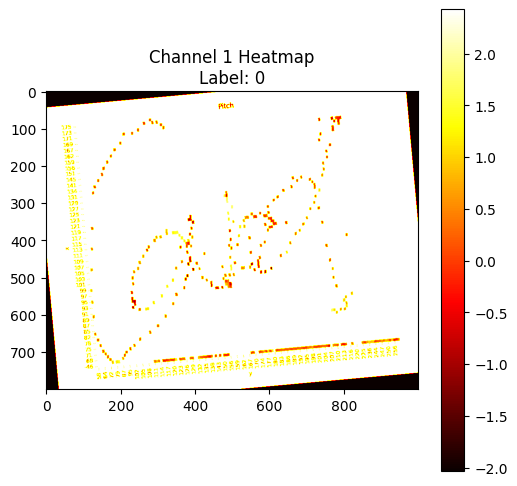

In [9]:
import matplotlib.pyplot as plt
import numpy as np
import torch  # 确保导入了torch

# 假设 image_data 是从数据集中获取的一个元素，形式为 (image, label)
image_data = signature_dataset[5]  # 假设signature_dataset是你的数据集
image, label = image_data  # 分别提取图像和标签

# 确保图像在CPU上
image = image.cpu()
print(image.shape)
# 选择要可视化的通道，例如第一个通道
channel = 1
if image.shape[0] == 4:
    image_rgb = image[:3, :, :]  # 选择前3个通道

# 将图像数据转换为NumPy数组，用于绘图
image_np = image_rgb.permute(1, 2, 0).numpy()  # 重新排列轴，以适应matplotlib的[H, W, C]格式

# 将图像通道数据转换为NumPy数组，用于绘图
image_channel = image[channel].numpy()

# 绘制热图
plt.figure(figsize=(6, 6))
plt.imshow(image_channel, cmap='hot')
plt.colorbar()  # 显示颜色条
plt.title(f'Channel {channel} Heatmap\nLabel: {label}')
plt.show()


In [ ]:
import torch
print('CUDA版本:',torch.version.cuda)
print('Pytorch版本:',torch.__version__)
print('显卡是否可用:','可用' if(torch.cuda.is_available()) else '不可用')
print('显卡数量:',torch.cuda.device_count())
print('是否支持BF16数字格式:','支持' if (torch.cuda.is_bf16_supported()) else '不支持')
print('当前显卡型号:',torch.cuda.get_device_name())
print('当前显卡的CUDA算力:',torch.cuda.get_device_capability())
print('当前显卡的总显存:',torch.cuda.get_device_properties(0).total_memory/1024/1024/1024,'GB')
print('是否支持TensorCore:','支持' if (torch.cuda.get_device_properties(0).major >= 7) else '不支持')
print('当前显卡的显存使用率:',torch.cuda.memory_allocated(0)/torch.cuda.get_device_properties(0).total_memory*100,'%')

CUDA版本: 12.1
Pytorch版本: 2.2.1+cu121
显卡是否可用: 可用
显卡数量: 4
是否支持BF16数字格式: 支持
当前显卡型号: NVIDIA GeForce RTX 3090
当前显卡的CUDA算力: (8, 6)
当前显卡的总显存: 23.69110107421875 GB
是否支持TensorCore: 支持
当前显卡的显存使用率: 28.9393855225361 %
